# House Prices Regression
William Yu

This is my submission to the beginner Kaggle Competition 'House Prices: Advanced Regression Techniques'. In this notebook, you will see examples of feature engineering and selection, as well as basic preprocessing and gradient boosting for the final model.

## Load/Preprocess Data

We first start by loading the necessary packages and the train and test set from Kaggle. There is an `Id` column in both the train and test set, which we can discard and save the test `Id` column for later once we export our predictions.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# read in train and test, save id for export
train = pd.read_csv('train.csv')
train = train.loc[:, train.columns != 'Id']
train = train.loc[:, train.columns != 'Id']


test = pd.read_csv('test.csv')
# save id's for export
id_copy = test.copy()
test = test.loc[:, test.columns != 'Id']
train.shape

(1460, 80)

Below I define a function to return the number of null values in each column in both the train and test set.

In [3]:
# view na and type to know how it fill
def view_na(df):
    types = []
    for i in df.columns:
        types.append(df[i].dtypes)
    type_df = pd.DataFrame(types, columns = ['type_na'])
    type_df.set_index(df.columns, inplace=True)

    na = pd.DataFrame(df.isna().sum(), columns=['num_na'])
    sorted_na = na.sort_values(['num_na'], ascending=False)
    #top_sorted_na = sorted_na[:40]
    na_df = sorted_na.merge(type_df, left_index=True, right_index = True)
    return na_df

train_na_df = view_na(train)
train_na_df.rename(columns={'num_na':'train_num_na'}, inplace=True)
test_na_df = view_na(test)
test_na_df.rename(columns={'num_na':'test_num_na'}, inplace=True)
test_na_df.drop(['type_na'], axis=1, inplace=True)
na_df = train_na_df.merge(test_na_df, left_index=True, right_index = True)
na_df = na_df.loc[:, ['train_num_na', 'test_num_na', 'type_na']]
na_df = na_df.sort_values(by=['train_num_na', 'test_num_na'], ascending=False)
na_df[:40]

,train_num_na,test_num_na,type_na
PoolQC,1453,1456,object
MiscFeature,1406,1408,object
Alley,1369,1352,object
Fence,1179,1169,object
FireplaceQu,690,730,object
LotFrontage,259,227,float64
GarageYrBlt,81,78,float64
GarageCond,81,78,object
GarageFinish,81,78,object
GarageQual,81,78,object


We see that in columns `PoolQC`, `MiscFeature`, `Alley`, and `Fence`, the majority of the values are null so we should drop them to prevent them in clouding our predictions.

In [5]:
# majority is na 
train.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence'], axis=1, inplace=True)
test.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence'], axis=1, inplace=True)

There is only one null value in Electrical in the train set so we can simply remove that entry:

In [6]:
# only one na in electrical
train.dropna(subset=['Electrical'], inplace=True)

As for the rest, the majority of the null values in these columns are omitted on purpose; for instance, a null value for any of the garage columns indicates that the house has no garage. We can fill these columns manually. 

However, as for a few other collumns, such as `LotFrontage` and `MSZoning`, we cannot say for certain what their null values are so we will be using KNNImputer and SimpleImputer to fill in these values. 

In [4]:
from sklearn.impute import SimpleImputer, KNNImputer

# can't say exterior 1st, sale type, functional or mszoning are none
cat_cols = ['FireplaceQu', 'GarageCond', 'GarageType', 'GarageFinish', 'GarageQual', 'BsmtExposure', 'BsmtFinType2',
            'BsmtCond', 'BsmtQual', 'BsmtFinType1', 'MasVnrType', 'KitchenQual', 
            'Exterior2nd']
for col in cat_cols:
    train[col] = train[col].fillna('None')
    test[col] = test[col].fillna('None')

numeric_cols = ['GarageYrBlt', 'GarageCars', 'GarageArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', 
                'BsmtUnfSF', 'BsmtHalfBath', 'BsmtFullBath']
for col in numeric_cols:
    train[col] = train[col].fillna(0)
    test[col] = test[col].fillna(0)

knn = KNNImputer()
train['LotFrontage'] = knn.fit_transform(train['LotFrontage'].to_numpy().reshape(-1,1))
test['LotFrontage'] = knn.fit_transform(test['LotFrontage'].to_numpy().reshape(-1,1))

impute = SimpleImputer(strategy='most_frequent')
impute_cols = ['Exterior1st', 'SaleType', 'Functional', 'MSZoning']
for col in impute_cols:
    test[col] = impute.fit_transform(test[col].to_numpy().reshape(-1,1))

Distribution of `LotArea` is skewed, apply a log-transformation to unskew:

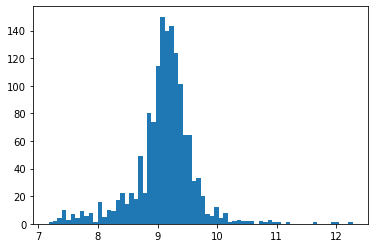

In [7]:
train['LotArea'] = np.log(train['LotArea'])
plt.hist(train['LotArea'], bins='auto')
test['LotArea'] = np.log(test['LotArea'])

We introduce a new feature here, `totalSF`, which is simply the total square feet of a house. 

In [8]:
train['totalSF'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']
test['totalSF'] = test['TotalBsmtSF'] + test['1stFlrSF'] + test['2ndFlrSF']

# high correlation
train.drop(['1stFlrSF'], inplace=True, axis=1)

Text(0, 0.5, 'SalePrice')

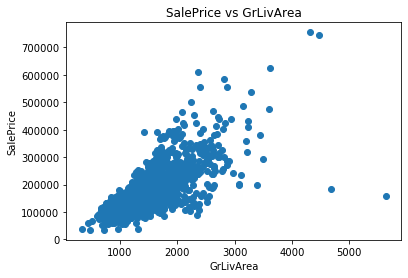

In [9]:
# remove outlier by recommendation of author
plt.scatter(train['GrLivArea'], train['SalePrice'])
plt.title('SalePrice vs GrLivArea')
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')

When we plot `GrLivArea` for the training set, we see that there are two outliers, in the `GrLivArea` > 4500 area. We remove them below.

In [10]:
# remove two outliers at GrLivArea > 4500
train = train[train["GrLivArea"] < 4500]

We introduce another feature, `AggBath`, which counts the total number of baths a house has. This will aid us in our model-fitting. 

We also cast some features as string, as these features should really be interpreted as such. These include `YrSold`, `MoSold`, and `MSSubClass`.

In [11]:
# get house age
train['AggBath'] = train['BsmtFullBath'] + 0.5*train['BsmtHalfBath'] + train['FullBath'] + 0.5*train['HalfBath']
test['AggBath'] = test['BsmtFullBath'] + 0.5*test['BsmtHalfBath'] + test['FullBath'] + 0.5*test['HalfBath']

train.drop(['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'Utilities'], inplace=True, axis=1)
test.drop(['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'Utilities'], inplace=True, axis=1)

train['YrSold'] = train['YrSold'].astype(str)
train['MoSold'] = train['MoSold'].astype(str)
train['MSSubClass'] = train['MSSubClass'].astype(str)

test['YrSold'] = test['YrSold'].astype(str)
test['MoSold'] = test['MoSold'].astype(str)
test['MSSubClass'] = test['MSSubClass'].astype(str)

In [12]:
init_X = train.loc[:, train.columns != 'SalePrice']

Below we view the correlation plot of our training data so we can remove highly correlated features.

In [13]:
corr_df = init_X.corr()
corr_df.style.background_gradient(cmap='coolwarm').set_precision(2)

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,2ndFlrSF,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,totalSF,AggBath
LotFrontage,1.00,0.56,0.22,-0.05,0.11,0.08,0.15,0.13,0.05,0.13,0.30,0.06,0.04,0.32,0.25,-0.00,0.31,0.22,0.10,0.28,0.30,0.07,0.11,0.01,0.07,0.04,0.10,0.00,0.37,0.18
LotArea,0.56,1.00,0.17,-0.00,0.02,0.02,0.11,0.21,0.09,0.08,0.33,0.07,0.01,0.38,0.28,0.00,0.35,0.32,0.14,0.27,0.31,0.20,0.13,0.01,0.06,0.10,0.06,0.05,0.43,0.23
OverallQual,0.22,0.17,1.00,-0.09,0.57,0.55,0.40,0.22,-0.06,0.31,0.54,0.29,-0.03,0.59,0.10,-0.18,0.42,0.39,0.29,0.60,0.56,0.24,0.30,-0.11,0.03,0.07,0.04,-0.03,0.68,0.54
OverallCond,-0.05,-0.00,-0.09,1.00,-0.38,0.08,-0.12,-0.04,0.04,-0.14,-0.18,0.03,0.03,-0.08,0.01,-0.09,-0.06,-0.02,-0.01,-0.19,-0.15,-0.00,-0.03,0.07,0.03,0.05,0.00,0.07,-0.15,-0.17
YearBuilt,0.11,0.02,0.57,-0.38,1.00,0.59,0.31,0.25,-0.05,0.15,0.40,0.01,-0.18,0.19,-0.07,-0.17,0.09,0.15,0.27,0.54,0.48,0.22,0.18,-0.39,0.03,-0.05,-0.01,-0.03,0.35,0.52
YearRemodAdd,0.08,0.02,0.55,0.08,0.59,1.00,0.17,0.12,-0.07,0.18,0.30,0.14,-0.06,0.29,-0.04,-0.15,0.19,0.11,0.15,0.42,0.37,0.20,0.22,-0.19,0.05,-0.04,-0.00,-0.01,0.35,0.44
MasVnrArea,0.15,0.11,0.40,-0.12,0.31,0.17,1.00,0.24,-0.07,0.11,0.34,0.17,-0.07,0.37,0.10,-0.04,0.27,0.24,0.13,0.36,0.36,0.16,0.10,-0.11,0.02,0.06,-0.02,-0.03,0.43,0.30
BsmtFinSF1,0.13,0.21,0.22,-0.04,0.25,0.12,0.24,1.00,-0.05,-0.52,0.47,-0.16,-0.07,0.14,-0.11,-0.08,0.01,0.24,0.12,0.23,0.27,0.21,0.07,-0.10,0.03,0.07,0.05,0.00,0.35,0.48
BsmtFinSF2,0.05,0.09,-0.06,0.04,-0.05,-0.07,-0.07,-0.05,1.00,-0.21,0.11,-0.10,0.01,-0.01,-0.02,-0.04,-0.03,0.05,0.04,-0.04,-0.02,0.07,0.00,0.04,-0.03,0.09,0.05,0.00,0.06,0.05
BsmtUnfSF,0.13,0.08,0.31,-0.14,0.15,0.18,0.11,-0.52,-0.21,1.00,0.44,0.00,0.03,0.25,0.17,0.03,0.25,0.05,0.04,0.21,0.18,-0.01,0.13,-0.00,0.02,-0.01,-0.03,-0.02,0.40,-0.11


In [14]:
# get features that have correlation > 0.75 
def high_corr(corr):
    high_corrs = []
    for col in corr.columns:
        index = corr[col].index
        for pos in range(len(index)):
            if np.abs(corr[col][pos]) >= 0.75 and index[pos] != col:
                high_corrs.append([col, index[pos], corr[col][pos]])
    
    # remove duplicates by score
    high_corrs= list(dict((x[2], x) for x in high_corrs).values())
    return high_corrs

high_corrs = high_corr(corr_df)
high_corrs

[['totalSF', 'TotalBsmtSF', 0.8062853036123125],
 ['TotRmsAbvGrd', 'GrLivArea', 0.829586936498805],
 ['totalSF', 'GrLivArea', 0.8665447506814179],
 ['GarageArea', 'GarageCars', 0.8874424754231299]]

So we know that `YearBuilt` and `GarageYrBlt`, `1stFlrSF` and `TotalBsmtSF`, `TotRmsAbvGrd` and `GrLivArea`, `GarageCars` and `GarageArea` are highly correlated. Thus, we can keep one of each of the correlated columns by choosing the column with the highest correlation with `SalePrice`.

In [15]:
# for each pair of correlated features
# remove feature that is least correlated with `SalePrice`
for high_corr in high_corrs:
    if np.abs(train[high_corr[0]].corr(train['SalePrice'])) > np.abs(train[high_corr[1]].corr(train['SalePrice'])):
        train = train.loc[:, train.columns != high_corr[1]]
    else: 
        train = train.loc[:, train.columns != high_corr[0]]

# reflect change in test set
cols = list(train.columns)
cols.remove('SalePrice')
test = test.loc[:, cols]

print(train.shape)
print(test.shape)

(1457, 68)
(1459, 67)


Only `YearBuilt`, `TotalBsmtSF`, `GrLivArea`, `GarageCars` are kept.

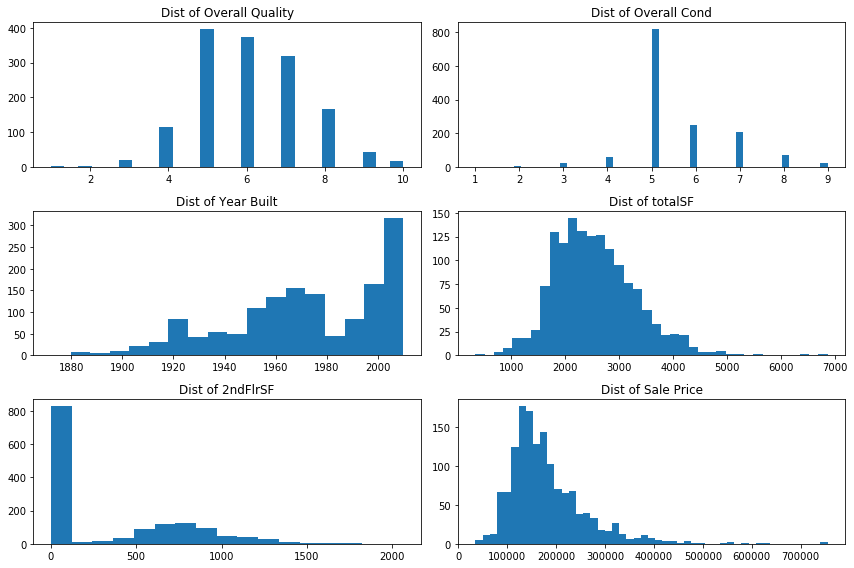

In [16]:
fig, ax = plt.subplots(3, 2, figsize=(12,8))
ax[0, 0].hist(train['OverallQual'], bins= 'auto')
ax[0, 0].set_title('Dist of Overall Quality')

ax[0, 1].hist(train['OverallCond'], bins= 'auto')
ax[0, 1].set_title('Dist of Overall Cond')

ax[1, 0].hist(train['YearBuilt'], bins= 'auto')
ax[1, 0].set_title('Dist of Year Built')

ax[1, 1].hist(train['totalSF'], bins= 'auto')
ax[1, 1].set_title('Dist of totalSF')

ax[2, 0].hist(train['2ndFlrSF'], bins= 'auto')
ax[2, 0].set_title('Dist of 2ndFlrSF')

ax[2, 1].hist(train['SalePrice'], bins= 'auto')
ax[2, 1].set_title('Dist of Sale Price')

plt.tight_layout()

In the plots above, we see that `SalePrice` is skewed heavily to the right, so we apply a log transform on it. We will be exponentiating our predictions later so that our predictions reflect the actual range of the house price.

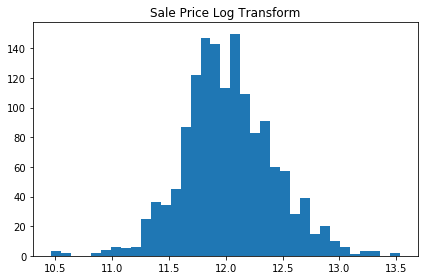

In [17]:
# log scale SalePrice
train['SalePrice'] = train['SalePrice'].apply(lambda x: np.log(x))
plt.hist(train['SalePrice'], bins= 'auto')
plt.title('Sale Price Log Transform')
plt.tight_layout()

## Feature Engineering & Selection

From reading the data description on Kaggle, we know that certain features have an explicit ordering to their values, so we can manually encode these values in an ordinal fashion.

In [18]:
# manually ordinal encode var
# Ex Excellent Gd Good TA Average/Typical Fa Fair Po Poor
quality_cols = ['ExterQual', 'ExterCond', 'HeatingQC', 'KitchenQual', 'BsmtQual', 'BsmtCond', 'FireplaceQu', 
                   'GarageQual', 'GarageCond']
for col in quality_cols:
    train[col] = train[col].map({"Ex": 5, "Gd": 4 , "TA": 3, "Fa":2, "Po":1, "None": 0})
    test[col] = test[col].map({"Ex": 5, "Gd": 4 , "TA": 3, "Fa":2, "Po":1, "None": 0})
    
quality_cols_bsmt = ['BsmtFinType1', 'BsmtFinType2']
for col in quality_cols_bsmt:
    train[col] = train[col].map({"GLQ": 6, "ALQ": 5, "BLQ": 4, "Rec":3, "LwQ":2, "Unf": 1, "None": 0})
    test[col] = test[col].map({"GLQ": 6, "ALQ": 5, "BLQ": 4, "Rec":3, "LwQ":2, "Unf": 1, "None": 0})

After manually encoding, we can move onto feature selection using Recursive Feature Elimination (RFE).

In [19]:
X = train.loc[:, train.columns != 'SalePrice']
y = train['SalePrice']
test_X = test.loc[:, test.columns != 'SalePrice']

In [20]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, RobustScaler, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
import category_encoders as ce
from sklearn.feature_selection import f_regression, chi2, SelectKBest, RFECV
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

We ordinal encode the rest of our variables to get a coherent response in our RFE. If we one-hot encode using RFE, then RFE may return some encodings for a feature but omit some encodings for the same feature, which doesn't really make sense.

On the other hand, ordinal encoding does introduce a linear relationship in the features, which is not good if there was no such relationship in the features in the first place. 

In [21]:
categorical = X.dtypes == 'object'

ord_pipe = make_pipeline(SimpleImputer(strategy='constant', fill_value='NaN'), 
                         OrdinalEncoder())

# pipline for cat, impute for cont
preprocess = make_column_transformer((ord_pipe, categorical),
                                    (KNNImputer(), ~categorical), )

X_transformed = preprocess.fit_transform(X)
test_transformed = preprocess.fit_transform(test_X)
transformed_df = pd.DataFrame(X_transformed, columns = X.columns)
test_transformed_df = pd.DataFrame(test_transformed, columns = test_X.columns)

In [22]:
import scipy.stats

fitted_data = transformed_df
fitted_data_test = test_transformed_df
#fitted_data = transformed_df.apply(lambda x: np.arcsinh(x)) 
#fitted_data_test = test_transformed_df.apply(lambda x: np.arcsinh(x)) 

In [23]:
rfe = RFECV(GradientBoostingRegressor(random_state=0), cv=KFold(10), scoring='neg_root_mean_squared_error')
rfe.fit(fitted_data, y)
print('Number of Features:',  rfe.n_features_)

Number of Features: 53


We fit the RFE model with a GradientBoostingRegressor and see that RFE returns 53 features to use for our modeling.

In [24]:
ord_subset = fitted_data.iloc[:, rfe.support_]
ord_subset_test = fitted_data_test.iloc[:, rfe.support_]

In [25]:
# add neighborhood to improve performance
ord_subset['Neighborhood'] = fitted_data['Neighborhood']
ord_subset_test['Neighborhood'] = fitted_data_test['Neighborhood']
X_train_ord, X_test_ord, y_train_ord, y_test_ord = train_test_split(ord_subset, y, random_state=0)

/Users/williamyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/williamyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


We GridSearch over the parameters for XGBoost and introduce KFolds to increase our validation accuracy. We get a RMSE of 0.11.

In [33]:
# RMSE:  -0.11256450647121108
rfe_param_grid = {"learning_rate": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
                  "max_depth": [ 3, 4, 5, 6, 8, 10, 12, 15],
                  "min_child_weight": [ 1, 3, 5, 7 ],
                  "gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
                  "colsample_bytree": [ 0.3, 0.4, 0.5 , 0.7 ]}
rfe_pipe = (XGBRegressor(random_state=0))
rfe_xgb = GridSearchCV(rfe_pipe, rfe_param_grid, cv=10, scoring='neg_root_mean_squared_error')
rfe_xgb.fit(X_train_ord, y_train_ord)
print('XGBoost best params: ', rfe_xgb.best_params_)
print('RMSE: ', rfe_xgb.score(X_test_ord, y_test_ord))

XGBoost best params:  {'colsample_bytree': 0.5, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 3}
RMSE:  -0.11223988140347844


We do the same with GradientBoosting and get a RMSE of 0.12.

In [38]:
# RMSE:  -0.12146287138899886
rfe_param_grid = {'max_depth': range(2, 22, 2), 
                  'learning_rate': [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
                  'max_features': ['log2','sqrt'],
                 'min_samples_leaf': [1, 2, 5, 10]}
rfe_pipe = (GradientBoostingRegressor(random_state=0))
rfe_grid = GridSearchCV(rfe_pipe, rfe_param_grid, cv=10, scoring='neg_root_mean_squared_error')
rfe_grid.fit(X_train_ord, y_train_ord)
print('GradientBoosting best params: ', rfe_grid.best_params_)
print('RMSE: ', rfe_grid.score(X_test_ord, y_test_ord))

GradientBoosting best params:  {'learning_rate': 0.1, 'max_depth': 4, 'max_features': 'sqrt'}
RMSE:  -0.12146287138899886


In [39]:
# xgb export
y_pred_xgb = rfe_xgb.predict(ord_subset_test)
exp_y_pred_xgb = np.exp(y_pred_xgb)
test['SalePrice'] = exp_y_pred_xgb
test['Id'] = id_copy['Id']
test_export = test.loc[:, ['Id', 'SalePrice']]
test_export.to_csv('houses_rfe_ord.csv', index=False)

In [40]:
# gb export
y_pred_gb = rfe_grid.predict(ord_subset_test)
exp_y_pred_gb = np.exp(y_pred_gb)
test['SalePrice'] = exp_y_pred_gb
test['Id'] = id_copy['Id']
test_export = test.loc[:, ['Id', 'SalePrice']]
test_export.to_csv('houses_rfe_gb.csv', index=False)

To achieve the best predictions, we take the log average of both the predictions from XGBoost and GradientBoosting, and finally exponentiate the result to get the final house prices. This achieved a RMSE of 0.12798, which placed us in the 30% percentile on the Kaggle Leaderboard. Thanks for reading!

In [41]:
# avg
y_pred_avg = np.exp((np.log(exp_y_pred_gb) + np.log(exp_y_pred_xgb)) / 2 )
test['SalePrice'] = y_pred_avg
test['Id'] = id_copy['Id']
test_export = test.loc[:, ['Id', 'SalePrice']]
test_export.to_csv('houses_rfe_avg.csv', index=False)